<div dir=rtl>
<h3>پروژه دوم مبانی داده کاوی</h3>
<h4>عرفان خوب شهمیری</h4>
<h4>مقداد دهقان</h4>
<p>
<a href="https://drive.google.com/file/d/1-7h35rfDOMqIVu8_8zhPcdr9hlwolyg8/view?usp=sharing">لینک دانلود بهترین مدل به دست آمده</a>

<a href="https://colab.research.google.com/drive/14pPoEwyXvncMKYxSy1Da2gUYuBItT6ea?usp=sharing">لینک کولب پروژه</a>
</p>
</div>
<br/>
<p>

Best model was RandomForestClassifier

Metrics of the best model : 

accuracy = 0.9617 , precision = 0.9709 , recall = 0.9391 , f1_score = 0.9547 

</p>
<br/>

<p>
List of all trained models :

dt_model = DecisionTreeClassifier

nb_model = GaussianNB ( naive bayes )

rf_model = RandomForestClassifier

kn_model = KNeighborsClassifier ( KNN )
</p>

In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time, pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from copy import deepcopy

df = pd.read_csv('/content/drive/MyDrive/flight.csv')
useless_columns = ['index','id']
df.drop(useless_columns, axis=1, inplace=True)
categories = ['Gender','Customer Type','Type of Travel','Class','satisfaction']

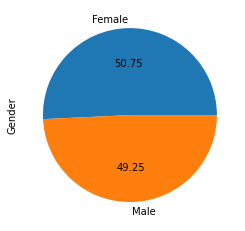

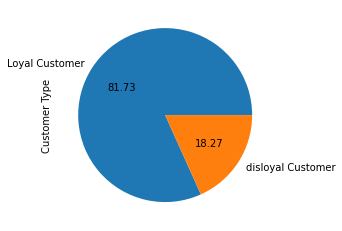

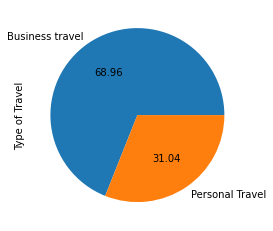

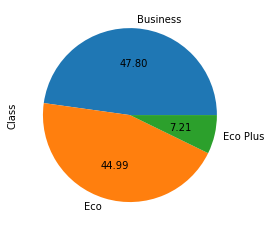

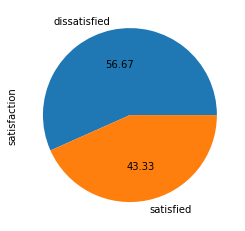

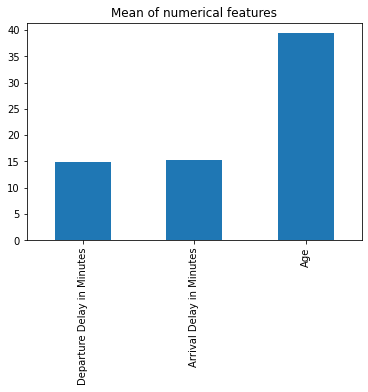

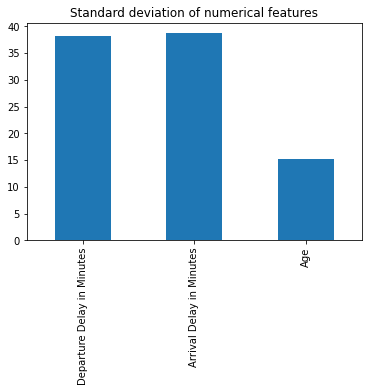

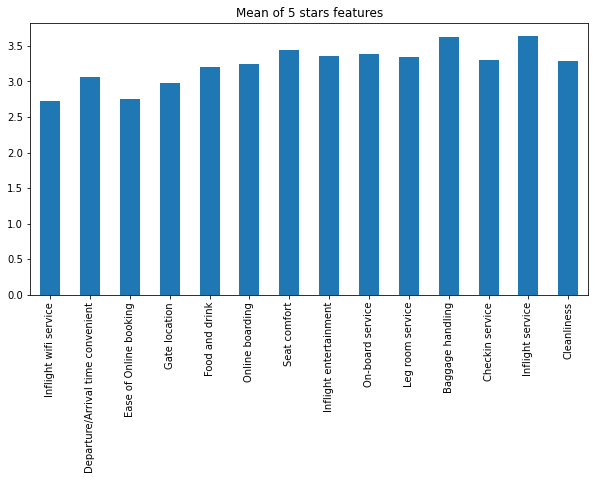

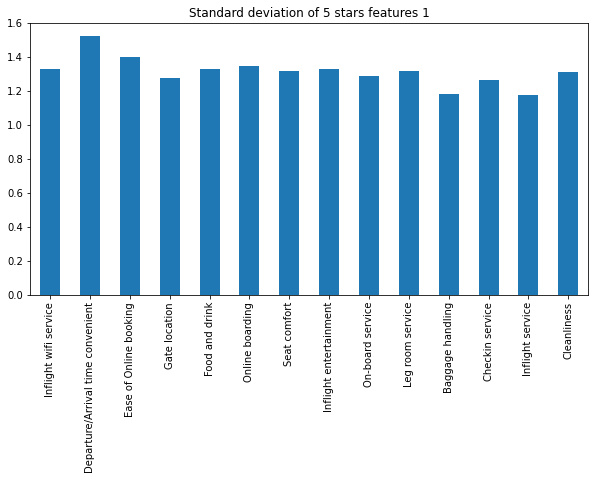

In [38]:
#EDA and charts
i = 0
for i in range(len(categories)) :
  plt.figure(i)
  df.groupby(categories[i]).size().plot(kind='pie', autopct='%.2f', label=categories[i])
non_scores = ['Departure Delay in Minutes','Arrival Delay in Minutes','Age']
df1 = df.drop(categories+['Flight Distance'], axis=1)
df2 = df1[non_scores]
i+=1
plt.figure(i)
df2.mean().plot(kind='bar', title='Mean of numerical features')  
i+=1
plt.figure(i)
df2.std().plot(kind='bar', title='Standard deviation of numerical features')

df3 = df1.drop(non_scores, axis=1)
i+=1
plt.figure(i)
df3.mean().plot(kind='bar',figsize=(10,5), title='Mean of 5 stars features')  
i+=1
plt.figure(i)
df3.std().plot(kind='bar',figsize=(10,5), title='Standard deviation of 5 stars features 1')   

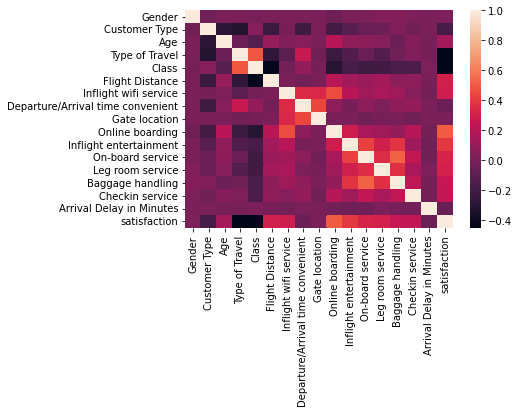

In [41]:
# Preprocessing
# encoding categorical data to numerical
le = LabelEncoder()
encoderMappings = {}
#df[categories] = df[categories].apply(le.fit_transform)
for category in categories :
  df[category] = le.fit_transform(df[category])
  encoderMappings[category] = dict(zip(le.transform(le.classes_), le.classes_))

#print(encoderMappings)
#df.to_csv('/content/drive/MyDrive/flight-encoded.csv')

# Dimensionality Reduction using High Correlation Filter
corr_matrix = df.corr()
sns.heatmap(corr_matrix)
corr_pairs = corr_matrix.unstack()
strong_pairs = corr_pairs[(abs(corr_pairs) >= 0.60) & ( corr_pairs!=1.0)].drop_duplicates()
#print(strong_pairs)
toBeRemoved = set()
for pair, value in strong_pairs.items():
    if abs(corr_matrix['satisfaction'][pair[0]]) > abs(corr_matrix['satisfaction'][pair[1]]) :
      toBeRemoved.add(pair[1])
    else :
      toBeRemoved.add(pair[0])

df.drop(list(toBeRemoved), axis=1, inplace=True)

#filling missing values
if df.isnull().values.any() :
  df.fillna(round(df.mean()), inplace=True)

In [40]:
#training and testing models

y_data = df['satisfaction']
x_data = df.drop('satisfaction', axis=1)
folds_number = 10

model_names = ['dt_model', 'nb_model', 'rf_model', 'kn_model']
metric_names = {'accuracy':accuracy_score, 'precision':precision_score, 'recall':recall_score,
                'f1_score':f1_score, 'confusion_matrix':confusion_matrix}
model_metrics = {}
train_time = {}
for model in model_names :
  train_time[model] = []
  model_metrics[model] = {}
  for metric in metric_names :
    model_metrics[model][metric] = []

kf = KFold(n_splits=folds_number)
best_model = None
best_score = 0
best_metrics = None

for train_index, test_index in kf.split(x_data):
  x_train , x_test = x_data.iloc[train_index,:] , x_data.iloc[test_index,:]
  y_train , y_test = y_data.iloc[train_index] , y_data.iloc[test_index]
  
  dt_model = DecisionTreeClassifier()
  start = time.time()
  dt_model.fit(x_train,y_train)
  stop = time.time()
  dt_predicted = dt_model.predict(x_test)
  for metric in metric_names :
    model_metrics['dt_model'][metric].append(metric_names[metric](y_test,dt_predicted))
  train_time['dt_model'].append(stop - start)
  new_score = model_metrics['dt_model']['accuracy'][-1]
  if( new_score > best_score) :
    best_score = new_score
    best_model = deepcopy(dt_model)
    best_metrics = { metric:values[-1] for metric, values in model_metrics['dt_model'].items() }

  nb_model = GaussianNB()
  start = time.time()
  nb_model.fit(x_train,y_train)
  stop = time.time()
  nb_predicted = nb_model.predict(x_test)
  for metric in metric_names :
    model_metrics['nb_model'][metric].append(metric_names[metric](y_test,nb_predicted))
  train_time['nb_model'].append(stop - start)
  new_score = model_metrics['nb_model']['accuracy'][-1]
  if( new_score > best_score) :
    best_score = new_score
    best_model = deepcopy(nb_model)
    best_metrics = { metric:values[-1] for metric, values in model_metrics['nb_model'].items() }

  rf_model = RandomForestClassifier()
  start = time.time()
  rf_model.fit(x_train,y_train)
  stop = time.time()
  rf_predicted = rf_model.predict(x_test)
  for metric in metric_names :
    model_metrics['rf_model'][metric].append(metric_names[metric](y_test,rf_predicted))
  train_time['rf_model'].append(stop - start)
  new_score = model_metrics['rf_model']['accuracy'][-1]
  if( new_score > best_score) :
    best_score = new_score
    best_model = deepcopy(rf_model)
    best_metrics = { metric:values[-1] for metric, values in model_metrics['rf_model'].items() }

  kn_model = KNeighborsClassifier()
  start = time.time()
  kn_model.fit(x_train,y_train)
  stop = time.time()
  kn_predicted = kn_model.predict(x_test)
  for metric in metric_names :
    model_metrics['kn_model'][metric].append(metric_names[metric](y_test,kn_predicted))
  train_time['kn_model'].append(stop - start)
  new_score = model_metrics['kn_model']['accuracy'][-1]
  if( new_score > best_score) :
    best_score = new_score
    best_model = deepcopy(kn_model)
    best_metrics = { metric:values[-1] for metric, values in model_metrics['kn_model'].items() }

print(f'Average metrics of models using {folds_number} fold cross validation :')
for model in model_names :
  print(f'{model} : ',end='')
  for metric in model_metrics[model] :
    if metric != 'confusion_matrix' :
      value = np.mean(model_metrics[model][metric])
      print(f'{metric} = {value:.4f}', end=' , ')
  print(f'training time = {np.mean(train_time[model]):.2f} seconds')
  matrix = model_metrics[model]['confusion_matrix'][0]
  print(f'confusion_matrix = {matrix}\n')

print(f'Best model is {type(best_model).__name__}')
print('Metrics of the best model : ')
for metric in best_metrics :
    if metric != 'confusion_matrix' :
      value = best_metrics[metric]
      print(f'{metric} = {value:.4f}', end=' , ')
matrix = best_metrics['confusion_matrix']
print(f'\nconfusion_matrix = {matrix}')
with open('/content/drive/MyDrive/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Average metrics of models using 10 fold cross validation :
dt_model : accuracy = 0.9387 , precision = 0.9276 , recall = 0.9314 , f1_score = 0.9294 , training time = 0.48 seconds
confusion_matrix = [[5564  337]
 [ 324 4166]]

nb_model : accuracy = 0.8670 , precision = 0.8695 , recall = 0.8155 , f1_score = 0.8416 , training time = 0.07 seconds
confusion_matrix = [[5313  588]
 [ 810 3680]]

rf_model : accuracy = 0.9581 , precision = 0.9672 , recall = 0.9350 , f1_score = 0.9508 , training time = 11.56 seconds
confusion_matrix = [[5739  162]
 [ 293 4197]]

kn_model : accuracy = 0.7578 , precision = 0.7379 , recall = 0.6841 , f1_score = 0.7100 , training time = 0.01 seconds
confusion_matrix = [[4799 1102]
 [1438 3052]]

Best model is RandomForestClassifier
Metrics of the best model : 
accuracy = 0.9617 , precision = 0.9709 , recall = 0.9391 , f1_score = 0.9547 , 
confusion_matrix = [[5794  126]
 [ 272 4198]]
